In [1]:
from utility_programs.read_routines import SAMI

In [2]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator, griddata
import numpy as np


from datetime import datetime
from tqdm.auto import tqdm
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

In [3]:
import interpolate_outputs

In [4]:
samipath = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'

In [57]:
interpolate_outputs.do_interpolations(samipath,
                                    out_path='/petastore/phil/Prasoon_satellite_project/satfiles/',
                                      dtime_sim_start='20130316',
                                    cols='edens',
                                      engine=None,
                                    save_delauney=True,
                                    show_progress=True)

attempting to reuse existing triangulation file


Reading in SAMI data:   0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

## If you make any changes to the source code, reimport it with:

(Then you don't have to restart the kernel)

In [5]:
import importlib

In [6]:
interpolate_outputs = importlib.reload(interpolate_outputs)

## Read in satellite file:

In [7]:
import pandas as pd

In [8]:
allsatdf = pd.read_csv('/petastore/phil/Prasoon_satellite_project/satfiles/20130317/DMSP_all-with_datetime.csv')

### Now grab just a single satellite's data

In [9]:
firstsat = allsatdf.loc[allsatdf.sat == 16].reset_index(drop=True)
# make sure to reset index & drop bad values, otherwise it's harder
firstsat

,glat,glon,time,sat,dayofyear,dtime
0,2.8,261.2,0.0,16,75,2013-03-16 00:00:00
1,6.3,260.5,60.0,16,75,2013-03-16 00:01:00
2,9.8,259.7,120.0,16,75,2013-03-16 00:02:00
3,13.3,258.9,180.0,16,75,2013-03-16 00:03:00
4,16.8,258.0,240.0,16,75,2013-03-16 00:04:00
...,...,...,...,...,...,...
4315,56.7,96.1,86100.0,16,77,2013-03-18 23:55:00
4316,53.3,94.3,86160.0,16,77,2013-03-18 23:56:00
4317,49.9,92.7,86220.0,16,77,2013-03-18 23:57:00
4318,46.5,91.2,86280.0,16,77,2013-03-18 23:58:00


In [31]:
latlon = [firstsat.glat, firstsat.glon]
latlon = np.array(latlon)

latlon

array([[  2.8,   6.3,   9.8, ...,  49.9,  46.5,  43. ],
       [261.2, 260.5, 259.7, ...,  92.7,  91.2,  89.9]])

In [32]:
# no alt in files, just assume it's 840 km. Add that to latlon object
alt = [840 for i in range(len(latlon[0]))]

In [34]:
# add in alt.
# Theres's a better way to do this but I don't remember...
latlonalt = (latlon[0], latlon[1], alt)
latlonalt = np.array(latlonalt)

In [35]:
latlonalt

array([[  2.8,   6.3,   9.8, ...,  49.9,  46.5,  43. ],
       [261.2, 260.5, 259.7, ...,  92.7,  91.2,  89.9],
       [840. , 840. , 840. , ..., 840. , 840. , 840. ]])

### Now send this in to the interpolation function

> I'm going to add a catch to make sure the file is readable by everyione in the `phil` group

Also make sure we get the dataset back. But this isn't necessary! Going to show an example where we just recalculate things and then read it back.

In [36]:
out_path = '/petastore/phil/Prasoon_satellite_project/'

sami_data_path = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'

In [38]:
ds = interpolate_outputs.do_interpolations(sami_data_path=sami_data_path,
                                     dtime_sim_start='20130316',
                                     out_lat_lon_alt=latlonalt,
                                     out_path=out_path,
                                     out_runname='-at-sat_16',
                                     save_delauney=True,
                                     max_alt=1500, #to make running faster. Not necessary.
                                     cols='edens',
                                    show_progress=True,
                                    engine='h5netcdf', #change to None if this makes errors
                                      return_ds_too=True
                                     )

attempting to reuse existing triangulation file


Reading in SAMI data:   0%|          | 0/596 [00:00<?, ?it/s]

In [98]:
## Don't forget to change the permissions!!

!chmod -R 770 {out_path}


#### To not get the datset back and then reafd it from the created file later:

i.e. you can run interpolation code in a console and then start a jupyter notebook to analyze things

In [ ]:
interpolate_outputs.do_interpolations(sami_data_path=sami_data_path,
                                     dtime_sim_start='20130316',
                                     out_latlonalt=latlonalt,
                                     out_path=out_path,
                                     out_runname='-at-sat_16',
                                     save_delauney=True,
                                     max_alt=1500, #to make running faster. Not necessary.
                                     cols='edens',
                                    show_progress=True,
                                    engine='h5netcdf', #change to None if this makes errors
                                     )

In [ ]:
## Don't forget to change the permissions!!

!chmod -R 770 {out_path}

In [ ]:
# then read the created file with:

import xarray as xr

ds = xr.open_datset(os.path.join(out_path, 'SAMI_REGRID-at-sat-16.nc'),
                   engine='h5netcdf') #set engine to the same one used to calculate interpolation.


## That's about all I have time for now. 


Should be simple enough, lol. I'm sure there will be problems. Let me know what they are and I'll fix them.

You can loop through multiple satellites by changing the '16' in each to the values of each satellite listed in the satfile. 

In [102]:
# see the available satellites:

np.unique(allsatdf.sat)

array([16, 17, 18])

In [ ]:
# loop through them:

for satnum in np.unique(allsatdf.sat):
    
    #set up output grid
    satnow = allsatdf.loc[allsatdf.sat == satnum].reset_index(drop=True)
    latlon = [firstsat.glat, firstsat.glon]
    latlon = np.array(latlon)
    alt = [840 for i in range(len(latlon[0]))]
    latlonalt = np.array([latlon[0], latlon[1], alt])
    
    interpolate_outputs.do_interpolations(sami_data_path=sami_data_path,
                                     dtime_sim_start='20130316',
                                     out_latlonalt=latlonalt,
                                     out_path=out_path,
                                     out_runname='-at-sat_' + str(satnum), 
                                          # to change the output name for each sat
                                     save_delauney=True,
                                     max_alt=1500, #to make running faster. Not necessary.
                                     cols='edens',
                                    show_progress=True,
                                    engine='h5netcdf', #change to None if this makes errors
                                     )


Then you have to read each satellite file individually with the code shown above

# Now Working on Next Issue

In [1]:
from utility_programs.read_routines import SAMI

from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator, griddata
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm.auto import tqdm
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import importlib
import interpolate_outputs



/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
allsatdf = pd.read_csv('/petastore/phil/Prasoon_satellite_project/satfiles/20130317/DMSP_all-with_datetime.csv')
samipath = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'

firstsat = allsatdf.loc[allsatdf.sat == 16].reset_index(drop=True)
# make sure to reset index & drop bad values, otherwise it's harder

latlon = [firstsat.glat, firstsat.glon]
latlon = np.array(latlon)

# no alt in files, just assume it's 840 km. Add that to latlon object
alt = [840 for i in range(len(latlon[0]))]

# add in alt.
# Theres's a better way to do this but I don't remember...
latlonalt = (latlon[0], latlon[1], alt)
latlonalt = np.array(latlonalt)

latlonalt

out_path = '/petastore/phil/Prasoon_satellite_project/'

sami_data_path = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'


In [ ]:
# see the available satellites:

interpolate_outputs = importlib.reload(interpolate_outputs)

np.unique(allsatdf.sat)

# loop through them:

for satnum in np.unique(allsatdf.sat):
    
    #set up output grid
    satnow = allsatdf.loc[allsatdf.sat == satnum].reset_index(drop=True)
    latlon = [firstsat.glat, firstsat.glon]
    latlon = np.array(latlon)
    alt = [840 for i in range(len(latlon[0]))]
    latlonalt = np.array([latlon[0], latlon[1], alt])
    
    dtime_sim_start = '201303' + str(satnum)
    
    ds = interpolate_outputs.do_interpolations(sami_data_path=sami_data_path,
                                     dtime_sim_start=dtime_sim_start,
                                     out_lat_lon_alt=latlonalt,
                                     out_path=out_path,
                                     out_runname='testing-at-sat_' + str(satnum), 
                                          # to change the output name for each sat
                                     save_delauney=True,
                                     max_alt=1500, #to make running faster. Not necessary.
                                     cols='edens',
                                    show_progress=True,
                                    engine='h5netcdf', #change to None if this makes errors
                                     return_ds_too=True
                                     )
    print(satnum)
    
    dtime_sim_start = '2013-03-' + str(satnum) + ' 16:30:00'
    
    ds.edens.sel(alt=300, time=dtime_sim_start, method='nearest').plot(x='lon', y='lat')
    
    print('done part 1')
    
    ds.edens.integrate('alt').sel(time = dtime_sim_start, method='nearest').plot(x='lon', y='lat')
    
    print('done part 2')
    
    print(satnum, 'complete')


In [ ]:
prasoon/data/SAMI3-GITM-python/test/SAMI_REGRID-at-sat_16.nc

In [3]:
interpolate_outputs = importlib.reload(interpolate_outputs)


day = 17

#set up output grid
satnow = allsatdf.loc[allsatdf.sat == satnum].reset_index(drop=True)
latlon = [firstsat.glat, firstsat.glon]
latlon = np.array(latlon)
alt = [840 for i in range(len(latlon[0]))]
#alt = [840, 850, 860, 870]

latlonalt = ([latlon[0], latlon[1], alt])

#dtime_sim_start = 

ds = interpolate_outputs.do_interpolations(sami_data_path=sami_data_path,
                                           dtime_sim_start='20130316',
                                           out_lat_lon_alt=latlonalt,
                                           out_path=out_path,
                                           out_runname='testing-at-sat_' + str(satnum), 
                                           # to change the output name for each sat
                                           save_delauney=True,
                                           max_alt=1500, #to make running faster. Not necessary.
                                           cols='edens',
                                           show_progress=True,
                                           engine='h5netcdf', #change to None if this makes errors
                                           return_ds_too=True
                                          )
print(day)


attempting to reuse existing triangulation file


writing Dataset...: : 597it [05:52,  1.69it/s]                                  


17


In [4]:
print(ds['edens']['time'])

<xarray.DataArray 'time' (time: 597)>
array(['2013-03-17T00:00:00.000000000', '2013-03-17T00:04:55.999200000',
       '2013-03-17T00:09:56.016000000', ..., '2013-03-19T01:29:56.400000000',
       '2013-03-19T01:34:55.200000000', '2013-03-19T01:39:54.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-03-17 ... 2013-03-19T01:39:54


2013-03-17 13:30:00
[840]
done part 1
done part 2


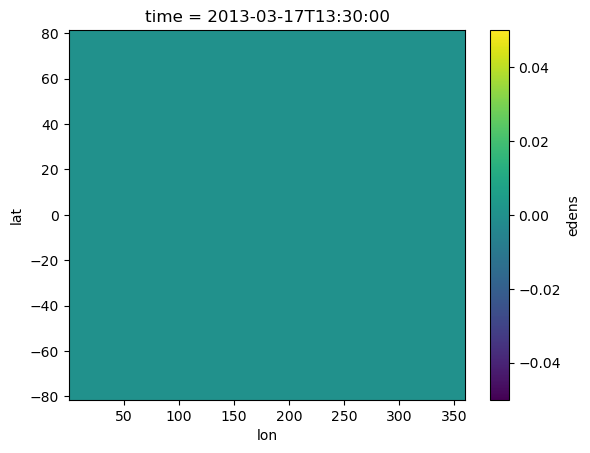

In [22]:
dtime = '2013-03-' + str(day) + ' 13:30:00'

print(dtime)

alt = sorted(set(alt))
print(alt)

#ds.edens.sel(alt=840, time=dtime_sim_start, method='nearest').plot(x='lon', y='lat')

print('done part 1')

ds.edens.integrate('alt').sel(time = dtime, method='nearest').plot(x='lon', y='lat')

print('done part 2')

2013-03-17 12:35:00
[840]
done part 1
done part 2


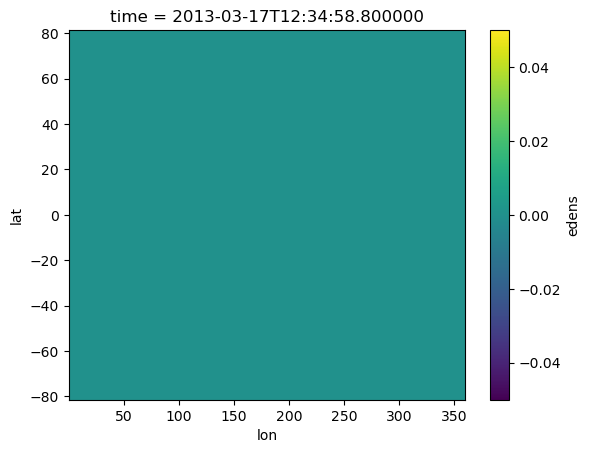

In [20]:
dtime_sim_start = '2013-03-' + str(satnum) + ' 12:35:00'

print(dtime_sim_start)

alt = sorted(set(alt))
print(alt)

#ds.edens.sel(alt=840, time=dtime_sim_start, method='nearest').plot(x='lon', y='lat')

print('done part 1')

ds.edens.integrate('alt').sel(time = dtime_sim_start, method='nearest').plot(x='lon', y='lat')

print('done part 2')

done part 2


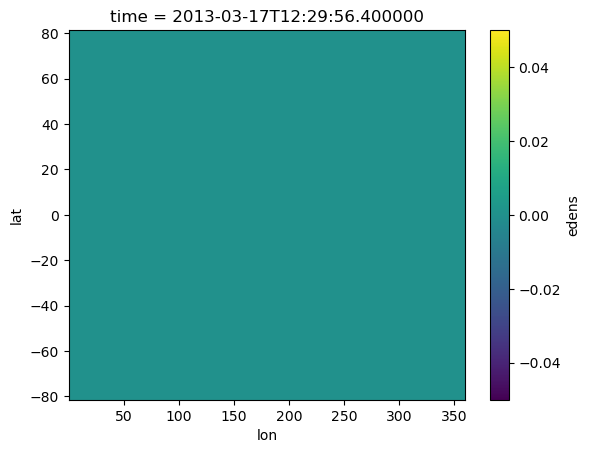

In [8]:
ds.edens.integrate('alt').sel(time = dtime_sim_start, method='nearest').plot(x='lon', y='lat')

print('done part 2')

In [23]:
a = range(10, 10-5,-1)

print(a[10:5])

for i in range(10, 10-5,-1):
    print(i)

range(5, 5, -1)
10
9
8
7
6


In [9]:
del ds

ds = xr.open_mfdataset('/petastore/phil/Prasoon_satellite_project/testing-at-sat_16_SAMI_REGRID.nc')

done part 1


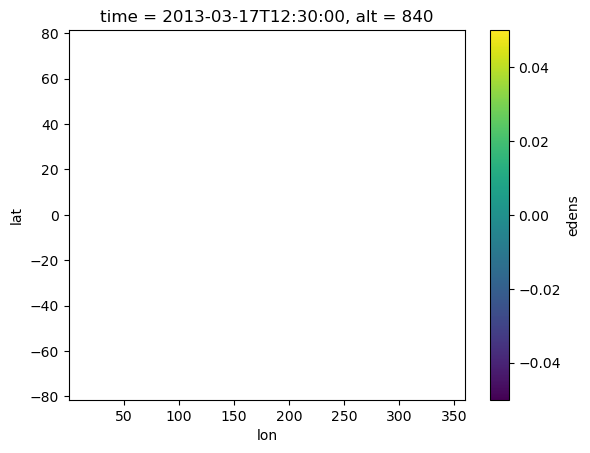

In [10]:
ds.edens.sel(alt=840, time=dtime_sim_start, method='nearest').plot(x='lon', y='lat')

print('done part 1')

done part 2


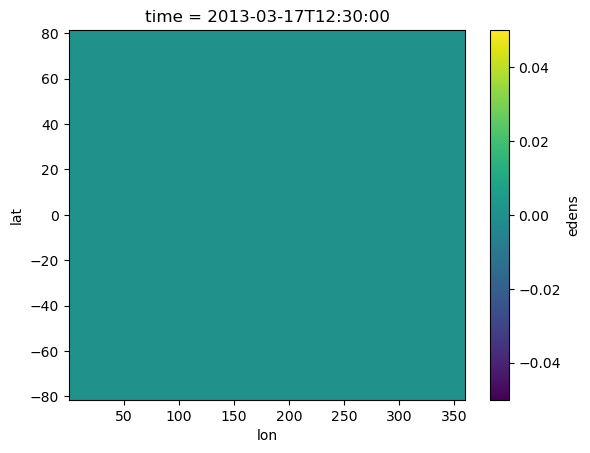

In [11]:
ds.edens.integrate('alt').sel(time = dtime_sim_start, method='nearest').plot(x='lon', y='lat')

print('done part 2')